# Fit Halo Mass from a Shear Catalog

_the LSST-DESC CLMM team_


This notebook demonstrates how to use `clmm` to estimate a WL halo mass from observations of a galaxy cluster.

## Setup

First, we import some standard packages.

In [1]:
from astropy.cosmology import FlatLambdaCDM
import matplotlib.pyplot as plt
# %matplotlib inline
import numpy as np
from numpy import random
from scipy import optimize as spo
import sys

Next, we import `clmm`'s core modules.

In [2]:
import clmm
import clmm.polaraveraging as pa
import clmm.galaxycluster as gc
import clmm.modeling as modeling

We then import a support modules for a specific data sets.
`clmm` includes support modules that enable the user to generate mock data in a format compatible with `clmm`.
We also provide support modules for processing other specific data sets for use with `clmm`.
Any existing support module can be used as a template for creating a new support module for another data set.
If you do make such a support module, please do consider making a pull request so we can add it for others to use.

In [3]:
sys.path.append('./support')
import mock_data as mock

## Making mock data

To create mock data, we need to define a true cosmology, which is currently done with [`astropy`'s cosmology library](http://docs.astropy.org/en/stable/cosmology/index.html).

In [4]:
mock_cosmo = FlatLambdaCDM(H0=70, Om0=0.27, Ob0=0.045)

We now set some parameters for a mock galaxy cluster.

In [5]:
cosmo = mock_cosmo
cluster_id = "Awesome_cluster"
cluster_m = 1.e15
cluster_z = 0.3
concentration = 4
ngals = 2000
Delta = 200
cluster_ra = 0.0
cluster_dec = 0.0

Then we use the `mock_data` support module to generate a new galaxy catalog. It includes sources distributed in redshift according to the Chang et al. (2013) distribution, with photometric redshift errors, and noise in the shape measurements. 

In [6]:
noisy_data_z = mock.generate_galaxy_catalog(cluster_m,
                                            cluster_z,
                                            concentration,
                                            cosmo,
                                            ngals,
                                            Delta,
                                            'chang13',
                                            shapenoise=0.01,
                                            photoz_sigma_unscaled=0.05)

This galaxy catalog is then converted to a `clmm.GalaxyCluster` object.

In [7]:
gc_object = clmm.GalaxyCluster(cluster_id, cluster_ra, cluster_dec,
                               cluster_z, noisy_data_z)

A `clmm.GalaxyCluster` object can be pickled and saved for later use.

In [8]:
gc_object.save('mock_GC.pkl')

Any saved `clmm.GalaxyCluster` object may be read in for analysis.

In [9]:
cl = clmm.load_cluster('mock_GC.pkl')
print("Cluster info = ID:", cl.unique_id, "; ra:", cl.ra, "; dec:", cl.dec, "; z_l :", cl.z)
print("The number of source galaxies is :", len(cl.galcat))

ra_l = cl.ra
dec_l = cl.dec
z = cl.z
e1 = cl.galcat['e1']
e2 = cl.galcat['e2']
ra_s = cl.galcat['ra']
dec_s = cl.galcat['dec']

Cluster info = ID: Awesome_cluster ; ra: 0.0 ; dec: 0.0 ; z_l : 0.3
The number of source galaxies is : 2000


We can visualize the distribution of galaxies on the sky.

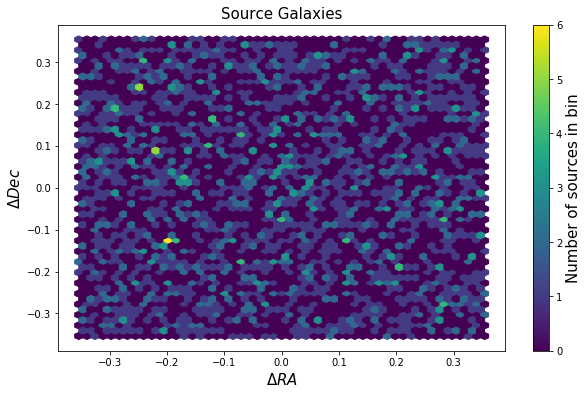

In [10]:
fsize = 15

fig = plt.figure(figsize=(10, 6))
hb = fig.gca().hexbin(ra_s, dec_s, gridsize=50)

cb = fig.colorbar(hb)
cb.set_label('Number of sources in bin', fontsize=fsize)

plt.gca().set_xlabel(r'$\Delta RA$', fontsize=fsize)
plt.gca().set_ylabel(r'$\Delta Dec$', fontsize=fsize)
plt.gca().set_title('Source Galaxies', fontsize=fsize)

plt.show()

`clmm` separates cosmology-dependent and cosmology-independent functionality.

## Deriving observables

We first demonstrate a few of the procedures one can perform on data without assuming a cosmology.

### Computing shear

`clmm.polaraveraging.compute_shear` calculates the tangential and cross shears for each source galaxy in the cluster.

In [11]:
theta, g_t, g_x = pa.compute_shear(cl, geometry="flat")

We can visualize the shear field at each galaxy location.

Text(0.5,0,'angular distance [rad]')

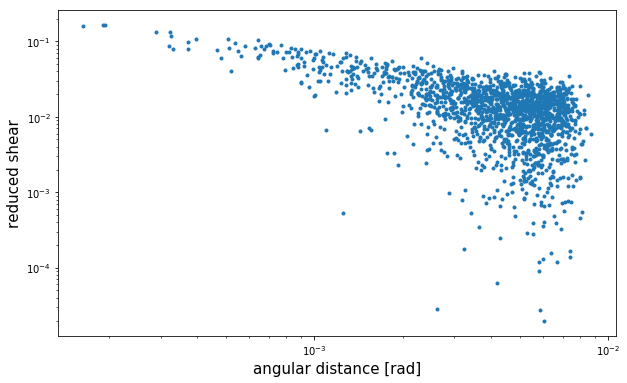

In [12]:
fig = plt.figure(figsize=(10, 6))

fig.gca().loglog(theta, g_t, '.')
plt.ylabel("reduced shear", fontsize=fsize)
plt.xlabel("angular distance [rad]", fontsize=fsize)

### Radially binning the data

Here we compare the reconstructed mass under two different bin definitions.

In [13]:
bin_edges = pa.make_bins(1, 4, 30, method='evenlog10width')

`clmm.polaraveraging.make_shear_profile` evaluates the average shear of the galaxy catalog in bins of radius.

In [14]:
profile = pa.make_shear_profile(cl, "radians", "Mpc", bins=bin_edges,cosmo=cosmo)

In [15]:
cl.profile

radius_min,radius,radius_max,gt,gt_err,gx,gx_err,z,z_err
float64,float64,float64,float64,float64,float64,float64,float64,float64
1.0,1.0278687994789915,1.0472941228206267,0.03810275676307849,0.004171822516481902,4.163336342344337e-18,1.0198049666328888e-18,1.0503255335182988,0.13804204162282613
1.0472941228206267,1.074131385214374,1.096824979694626,0.04460496517337894,0.006222905312733642,2.8912057932946783e-19,1.3629274814963324e-19,0.8264704506586235,0.11398573439263127
1.096824979694626,1.1325284228720367,1.148698354997035,0.04444169230227567,0.0019349182793455659,2.2551405187698493e-18,8.180835260989947e-19,1.4149918107483148,0.13847995736107485
1.148698354997035,1.1850103414883004,1.2030250360821166,0.03902117764685177,0.0019818953781613204,-2.846030702774449e-19,1.0966833599008951e-19,1.149627515811656,0.058600948941888234
1.2030250360821166,1.235007249420287,1.2599210498948732,0.03518521929088925,0.0016370690242894447,1.4193192076173877e-18,5.447656104277529e-19,1.2988337786947526,0.051171954018110435
1.2599210498948732,1.2871379134099075,1.3195079107728942,0.040571112442253775,0.0015434867512432967,5.312590645178972e-18,1.6730099377777934e-18,1.793017547933443,0.15998012844387333
1.3195079107728942,1.3434486345468541,1.381912879967776,0.04043218717695357,0.0035277248659868394,-4.336808689942018e-19,1.3437110265466432e-19,0.9611421460245733,0.054317206699936484
1.381912879967776,1.417283276875425,1.4472692374403782,0.032424856397955434,0.002153967499333128,2.3852447794681098e-18,7.109589093988369e-19,1.0023087874488088,0.0587936676594444
1.4472692374403782,1.4820720360046875,1.515716566510398,0.03531261285778875,0.0017085117139501527,2.529805069132844e-19,1.1122821240812142e-19,1.45014379038058,0.11082007383560101


For later use, we'll define some variables for the binned radius and tangential shear.

We visualize the radially binned shear for our mock galaxies.

Text(0,0.5,'$g_t$')

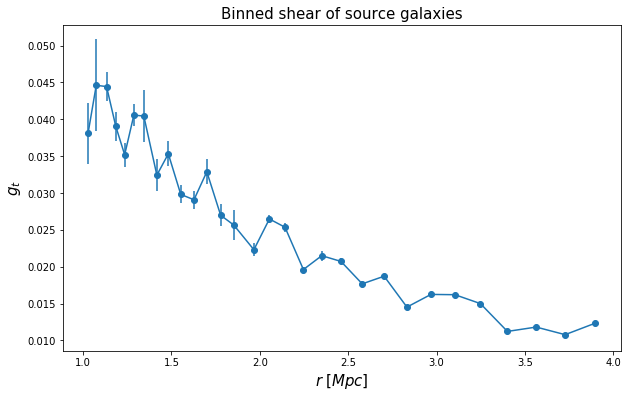

In [16]:
fig = plt.figure(figsize=(10, 6))

fig.gca().errorbar(profile['radius'], profile['gt'], yerr=profile['gt_err'], marker='o')

plt.gca().set_title(r'Binned shear of source galaxies', fontsize=fsize)
plt.gca().set_xlabel(r'$r\;[Mpc]$', fontsize=fsize)
plt.gca().set_ylabel(r'$g_t$', fontsize=fsize)

After running `clmm.polaraveraging.make_shear_profile` on a `clmm.GalaxyCluster` object, the object acquires the `clmm.GalaxyCluster.profile` attribute.

## Modeling the data

We next demonstrate a few of the procedures one can perform once a cosmology has been chosen.

### Create the halo model

`clmm.modeling.predict_reduced_tangential_shear` supports various parametric halo profile functions, including `nfw`.
`clmm.modeling` works in units of $Mpc/h$, whereas the data is cosmology-independent, with units of $Mpc$.

Below, we show to minimization methods. Either minimizing the chi2 using `scipy.optimize.minimize`, or fitting the model to the data using `scipy.optimize.curve_fit`

In [17]:
# chi2 definition to be used with scipy.optimize.minimize
def chi2(logm, profile_info):
    [r, gt, gt_err, z_src] = profile_info
    m = 10.**logm
    gt_model = clmm.predict_reduced_tangential_shear(r*cosmo.h,
                                                     m, concentration,
                                                     cluster_z, z_src, cosmo,
                                                     delta_mdef=200,
                                                     halo_profile_model='nfw')
    return sum(((gt_model - gt)/gt_err)**2)

In [18]:
# model definition to be used with scipy.optimize.curve_fit
def shear_profile_model(r, logm, z_src):
    m = 10.**logm
    gt_model = clmm.predict_reduced_tangential_shear(r*cosmo.h,
                                                     m, concentration,
                                                     cluster_z, z_src, cosmo,
                                                     delta_mdef=200,
                                                     halo_profile_model='nfw')
    return gt_model

### Fitting a halo mass

We optimize to find the best-fit mass for the data under the two radial binning schemes.

In [19]:
# example using scipy.optimize.minimize
logm_0 = random.uniform(13., 17., 1)[0]

logm_est = spo.minimize(chi2, logm_0,
                        args=[profile['radius'], profile['gt'], profile['gt_err'], profile['z']])

m_est = 10.**logm_est.x
print(f'Best fit mass = {m_est[0]} Msun')



Best fit mass = 832037622709855.4 Msun


In [20]:
# example using scipy.optimize.curve_fit

popt,pcov = spo.curve_fit(lambda r, logm:shear_profile_model(r, logm, profile['z']), 
                    profile['radius'], 
                    profile['gt'], 
                    sigma=profile['gt_err'], bounds=[13.,17.])

m_est = 10.**popt[0]

# convert the error on logm to error on m
m_est_err =  m_est * np.sqrt(pcov[0][0]) * np.log(10) 
print(f'Best fit mass = {m_est} +/- {m_est_err} Msun')

Best fit mass = 832037606366864.1 +/- 19507769229965.67 Msun


Next, we calculate the reduced tangential shear predicted by the model when using the average redshift of the catalog.

In [21]:
rr = np.logspace(-0.5, np.log10(5), 100)

gt_model = clmm.predict_reduced_tangential_shear(rr*cosmo.h,
                                                  m_est, concentration,
                                                  cluster_z, np.mean(cl.galcat['z']), cosmo,
                                                  delta_mdef=200,
                                                  halo_profile_model='nfw')

We visualize that prediction of reduced tangential shear along with the data

Text(0,0.5,'reduced tangential shear')

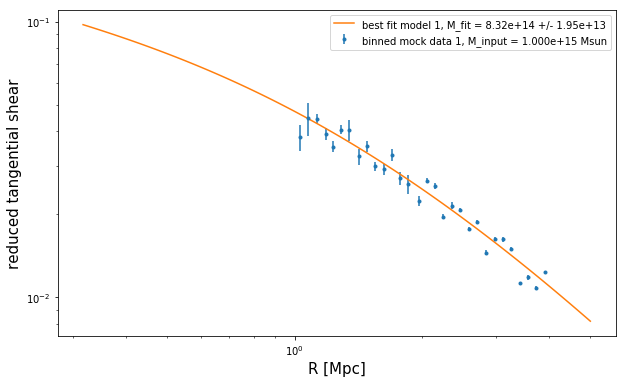

In [22]:
fig = plt.figure(figsize=(10, 6))

fig.gca().errorbar(profile['radius'], profile['gt'],profile['gt_err'],
                  label='binned mock data 1, M_input = %.3e Msun' % cluster_m, fmt='.')
fig.gca().plot(rr, gt_model,
               label='best fit model 1, M_fit = %.2e +/- %.2e' % (m_est, m_est_err))

plt.semilogx()
plt.semilogy()

plt.legend()
plt.xlabel('R [Mpc]', fontsize=fsize)
plt.ylabel('reduced tangential shear', fontsize=fsize)